# Learning Linear Mixed Models on a Simple Real Dataset

In this notebook we will:
- Use a **small, real, interpretable dataset** with clear grouping structure.
- Fit a **Linear Mixed Model (LMM)** and compare it to:
  - A plain linear regression (no random effects).
  - A model with many fixed effects (dummy variables).
- Discuss **when LMMs work well vs when they don't**.
- Show how to get an **approximate distribution for predictions** from an LMM.


## 1. Dataset choice: `sleepstudy` (reaction time and sleep deprivation)

We'll use the classic `sleepstudy` dataset from Pinheiro & Bates (2000), available via `lme4` (R) and `statsmodels` datasets.
It has:
- **Subjects**: 18 people (groups).
- **Days**: days of sleep deprivation (0-9).
- **Reaction**: reaction time (ms).

We expect different subjects to have different baseline reaction times and possibly different slopes over days. This is a textbook scenario for LMMs.


In [1]:
# Imports and dataset loading
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, root_mean_squared_error

# Load the sleepstudy dataset from statsmodels
sleep = sm.datasets.get_rdataset('sleepstudy', package='lme4').data
sleep


,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


## 2. Exploratory data analysis and grouping structure

We have repeated measurements (Days) for each Subject. Let's visualize reaction over days by subject.


In [2]:
sleep['Subject'] = sleep['Subject'].astype('category')
sleep.describe(include='all')


,Reaction,Days,Subject
count,180.000000,180.000000,180.0
unique,NaN,NaN,18.0
top,NaN,NaN,308.0
freq,NaN,NaN,10.0
mean,298.507892,4.500000,NaN
std,56.328757,2.880293,NaN
min,194.332200,0.000000,NaN
25%,255.375825,2.000000,NaN
50%,288.650800,4.500000,NaN
75%,336.752075,7.000000,NaN


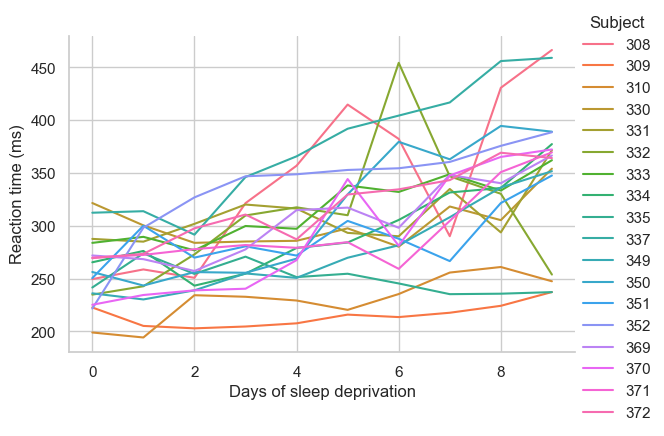

In [3]:
g = sns.relplot(
    data=sleep,
    x='Days', y='Reaction', hue='Subject',
    kind='line', estimator=None, units='Subject',
    height=4, aspect=1.5
)
g.set_axis_labels('Days of sleep deprivation', 'Reaction time (ms)')


You can see:
- Subjects have **different baselines** (intercepts).
- Many have roughly **linear increases** in reaction over days, but with slightly different slopes.

This suggests:
- A fixed effect for **Days** (overall trend).
- Random intercepts and possibly random slopes for **Subject**.


## 3. Baseline: simple linear regression (ignoring grouping)

First, we ignore which subject each observation comes from and fit a single linear regression:
$$ \text{Reaction} = \beta_0 + \beta_1 \text{Days} + \varepsilon. $$

This assumes *everyone* shares the same intercept and slope.


In [4]:
ols_model = smf.ols('Reaction ~ Days', data=sleep).fit()
print(ols_model.summary())

sleep['pred_ols'] = ols_model.predict(sleep)
rmse_ols = root_mean_squared_error(sleep['Reaction'], sleep['pred_ols'])
rmse_ols

                            OLS Regression Results                            
Dep. Variable:               Reaction   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.282
Method:                 Least Squares   F-statistic:                     71.46
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           9.89e-15
Time:                        18:50:46   Log-Likelihood:                -950.15
No. Observations:                 180   AIC:                             1904.
Df Residuals:                     178   BIC:                             1911.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    251.4051      6.610     38.033      0.0

47.448897509757494

Let's see how this global line fits a few subjects.


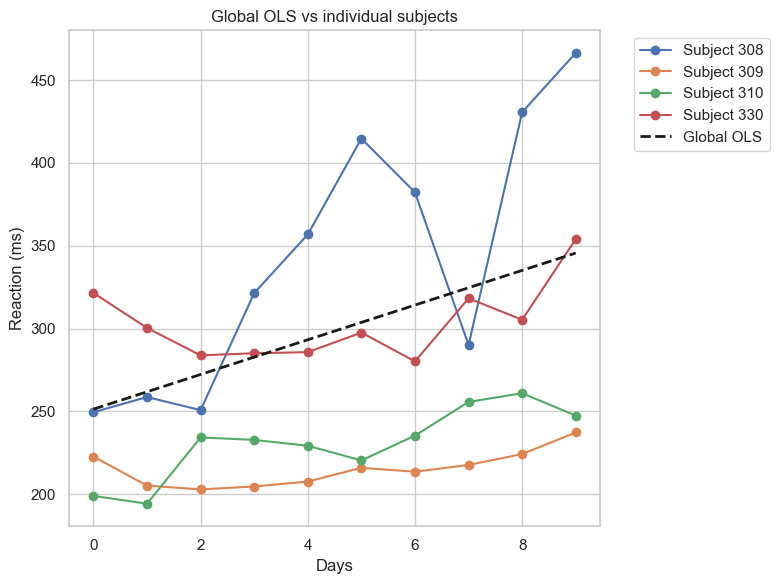

In [5]:
subset_subjects = sleep['Subject'].cat.categories[:4]
sub = sleep[sleep['Subject'].isin(subset_subjects)].copy()

plt.figure(figsize=(8, 6))
for s in subset_subjects:
    tmp = sub[sub['Subject'] == s]
    plt.plot(tmp['Days'], tmp['Reaction'], 'o-', label=f'Subject {s}')

# Global OLS line
days_grid = np.linspace(sleep['Days'].min(), sleep['Days'].max(), 100)
ols_line = ols_model.predict(pd.DataFrame({'Days': days_grid}))
plt.plot(days_grid, ols_line, 'k--', linewidth=2, label='Global OLS')

plt.xlabel('Days')
plt.ylabel('Reaction (ms)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Global OLS vs individual subjects')
plt.tight_layout()


The global line clearly **does not capture** subject-level differences. Residuals will be correlated within subject and the model underestimates uncertainty.


## 4. Many fixed effects: per-subject intercepts

Next, we allow each subject to have its own intercept, but keep a common slope for Days:
$$ \text{Reaction} = \beta_0 + \beta_1 \text{Days} + \sum_j \gamma_j 1\{\text{Subject}=j\} + \varepsilon. $$

This is still an OLS model, just with dummy variables for Subject. This can fit the data better but **does not share strength** between subjects.


In [6]:
fe_model = smf.ols('Reaction ~ Days + C(Subject)', data=sleep).fit()
print(fe_model.summary().tables[1])

sleep['pred_fe'] = fe_model.predict(sleep)
rmse_fe = root_mean_squared_error(sleep['Reaction'], sleep['pred_fe'])
rmse_fe

                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           295.0310     10.447     28.240      0.000     274.400     315.662
C(Subject)[T.309]  -126.9008     13.860     -9.156      0.000    -154.271     -99.531
C(Subject)[T.310]  -111.1326     13.860     -8.018      0.000    -138.503     -83.762
C(Subject)[T.330]   -38.9124     13.860     -2.808      0.006     -66.283     -11.542
C(Subject)[T.331]   -32.6978     13.860     -2.359      0.020     -60.068      -5.328
C(Subject)[T.332]   -34.8318     13.860     -2.513      0.013     -62.202      -7.462
C(Subject)[T.333]   -25.9755     13.860     -1.874      0.063     -53.346       1.395
C(Subject)[T.334]   -46.8318     13.860     -3.379      0.001     -74.202     -19.462
C(Subject)[T.335]   -92.0638     13.860     -6.643      0.000    -119.434     -64.694
C(Subject)[T.337]    33.5872     13.860      2.423    

29.309982107687237

## 5. Linear Mixed Model: random intercepts (and slopes) by subject

Now we treat subject-specific intercepts (and possibly slopes) as **random effects**:

Random-intercept model:
$$ \text{Reaction}_{ij} = (\beta_0 + b_{0j}) + \beta_1 \text{Days}_{ij} + \varepsilon_{ij}, $$
with $b_{0j} \sim N(0, \sigma_b^2)$ and $\varepsilon_{ij} \sim N(0, \sigma^2)$.

Random-intercept and random-slope model:
$$ \text{Reaction}_{ij} = (\beta_0 + b_{0j}) + (\beta_1 + b_{1j}) \text{Days}_{ij} + \varepsilon_{ij}. $$

Here each subject $j$ has its own intercept and slope, but they are assumed to come from a common Gaussian distribution. This induces **partial pooling**:
- Subjects with few data points are shrunk toward the global trend.
- Subjects with many data points can deviate more.


In [7]:
# Random-intercept model: Reaction ~ Days with random intercept for Subject
md_ri = smf.mixedlm('Reaction ~ Days', data=sleep, groups=sleep['Subject'])
lmm_ri = md_ri.fit(method='lbfgs')
print(lmm_ri.summary())

re_params = lmm_ri.random_effects  # dict: group -> random intercept(s)
groups = lmm_ri.model.groups

# Without rand_intercepts, this would be OLS predictions
sleep['pred_lmm_ri'] = lmm_ri.predict(sleep) + np.array([re_params[g][0] for g in groups])
rmse_lmm_ri = root_mean_squared_error(sleep['Reaction'], sleep['pred_lmm_ri'])
rmse_lmm_ri

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: Reaction 
No. Observations:  180     Method:             REML     
No. Groups:        18      Scale:              960.4529 
Min. group size:   10      Log-Likelihood:     -893.2325
Max. group size:   10      Converged:          Yes      
Mean group size:   10.0                                 
--------------------------------------------------------
           Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  251.405    9.747 25.793 0.000 232.302 270.509
Days        10.467    0.804 13.015 0.000   8.891  12.044
Group Var 1378.232   17.157                             




29.410615764628552

In [8]:
# Random-intercept + random-slope model
md_rs = smf.mixedlm('Reaction ~ Days', data=sleep, groups='Subject', re_formula='1 + Days')
lmm_rs = md_rs.fit(method='lbfgs')
print(lmm_rs.summary())

rs_params = lmm_rs.random_effects  # dict: group -> Series with keys like 'Subject' and 'Days'

# Build per-row random intercept and slope vectors by mapping the Subject for each row.
# Ensure the resulting Series are numeric (float) rather than categorical to avoid dtype errors.
rand_intercept = sleep['Subject'].map(lambda g: float(rs_params[int(g)]['Subject'])).astype(float)
rand_slope = sleep['Subject'].map(lambda g: float(rs_params[int(g)]['Days'])).astype(float)

# lmm_rs.predict(sleep) gives the fixed-effect part; add per-row random effects
sleep['pred_lmm_rs'] = lmm_rs.predict(sleep) + rand_intercept + rand_slope * sleep['Days']

rmse_lmm_rs = root_mean_squared_error(sleep['Reaction'], sleep['pred_lmm_rs'])
rmse_lmm_rs

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    Reaction 
No. Observations:    180        Method:                REML     
No. Groups:          18         Scale:                 654.9412 
Min. group size:     10         Log-Likelihood:        -871.8141
Max. group size:     10         Converged:             Yes      
Mean group size:     10.0                                       
----------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          251.405    6.825 36.838 0.000 238.029 264.781
Days                10.467    1.546  6.771 0.000   7.438  13.497
Subject Var        612.089   11.881                             
Subject x Days Cov   9.605    1.820                             
Days Var            35.072    0.610                             



23.438059898940374

## 6. Compare in-sample fit (RMSE)


In [9]:
results = pd.DataFrame({
    'model': [
        'OLS (no subject)',
        'OLS with subject dummies',
        'LMM: random intercept',
        'LMM: random intercept + slope'
    ],
    'RMSE': [rmse_ols, rmse_fe, rmse_lmm_ri, rmse_lmm_rs]
})
results

,model,RMSE
0,OLS (no subject),47.448898
1,OLS with subject dummies,29.309982
2,LMM: random intercept,29.410616
3,LMM: random intercept + slope,23.438060


Text(0.5, 1.0, 'In-sample RMSE comparison')

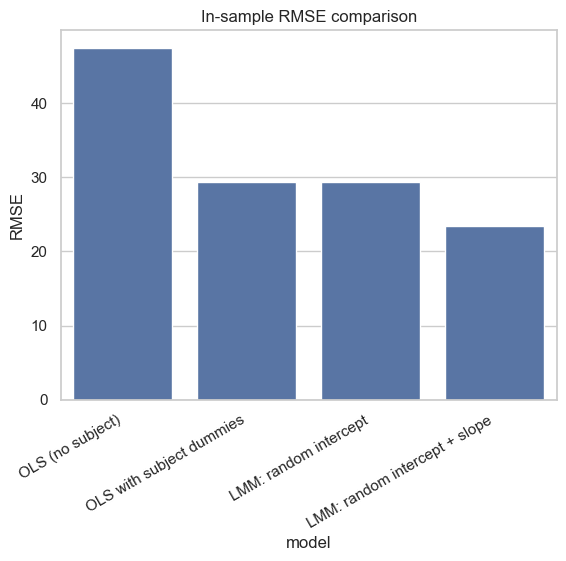

In [10]:
sns.barplot(data=results, x='model', y='RMSE')
plt.xticks(rotation=30, ha='right')
plt.title('In-sample RMSE comparison')


### When does LMM help here?

- Compared to **OLS without subject**, LMM handles within-subject correlation and allows different baselines (and slopes).
- Compared to **many fixed effects**, LMM:
  - Uses fewer parameters (variances of random effects instead of one parameter per subject).
  - Naturally shrinks extreme subjects toward the overall mean (partial pooling).
  - Usually generalizes better when you have many groups with few observations each.


## 7. Distribution of predictions from an LMM

An LMM is a **Gaussian hierarchical model**. For the random-intercept model:
$$ y_{ij} = (\beta_0 + b_{0j}) + \beta_1 x_{ij} + \varepsilon_{ij}, $$
with $b_{0j} \sim N(0, \sigma_b^2)$ and $\varepsilon_{ij} \sim N(0, \sigma^2)$.

Conditioned on the fitted parameters ($\hat{\beta}$, $\hat{\sigma}^2$, $\hat{\sigma}_b^2$) and the estimated random effects $\hat b_{0j}$, the **conditional predictive distribution** for an existing subject $j$ is approximately:
$$ y_{ij}^{\text{new}} \mid \hat{\beta}, \hat{b}_{0j} \sim N(\mu_{ij}, \sigma^2), $$
where $\mu_{ij}$ is what LMM predicts.

For a **new subject not in the training data**, we don't know $b_{0j}$, so we integrate over its distribution:
$$ y_{ij}^{\text{new}} \mid \hat{\beta} \sim N(\mu_{ij}^{\text{(no RE)}}, \sigma^2 + \sigma_b^2). $$

Below we show how to approximate prediction intervals using these variances.


In [11]:
# Extract residual variance (sigma^2) and random-intercept variance (sigma_b^2)
sigma2_eps = lmm_ri.scale
sigma2_b = float(lmm_ri.cov_re.iloc[0, 0])
sigma2_eps, sigma2_b

(np.float64(960.4529209939508), 1378.2320502560074)

In [14]:
# 95% predictive intervals for EXISTING subjects (conditional on their estimated random effects)
sleep['mean_pred_lmm_ri'] = sleep['pred_lmm_ri']
sleep['pred_std_existing'] = np.sqrt(sigma2_eps)
z = 1.96
sleep['pi_low_existing'] = sleep['mean_pred_lmm_ri'] - z * sleep['pred_std_existing']
sleep['pi_high_existing'] = sleep['mean_pred_lmm_ri'] + z * sleep['pred_std_existing']
sleep[['Reaction', 'mean_pred_lmm_ri', 'pi_low_existing', 'pi_high_existing']]


,Reaction,mean_pred_lmm_ri,pi_low_existing,pi_high_existing
0,249.5600,292.188928,231.446225,352.931631
1,258.7047,302.656214,241.913511,363.398917
2,250.8006,313.123500,252.380797,373.866203
3,321.4398,323.590786,262.848083,384.333489
4,356.8519,334.058072,273.315369,394.800775
...,...,...,...,...
175,329.6076,321.857332,261.114629,382.600034
176,334.4818,332.324618,271.581915,393.067320
177,343.2199,342.791904,282.049201,403.534606
178,369.1417,353.259190,292.516487,414.001892


In [13]:
# For a NEW subject j*, predictive variance is approx sigma2_eps + sigma2_b
pred_std_new_subject = np.sqrt(sigma2_eps + sigma2_b)
pred_std_new_subject


np.float64(48.35995214275918)

This shows two important points:
- For **existing subjects**, our uncertainty is mostly residual noise $\sigma^2$.
- For **new subjects**, uncertainty is larger because we add the variability of the random intercept $\sigma_b^2$.

Statsmodels does not automatically give full predictive intervals including parameter uncertainty in $\beta$ and $b_{0j}$, but the plug-in Normal approximation above is common in practice and often reasonable when sample sizes per group are not tiny.


## 8. When do LMMs work well, and when not?

**LMMs tend to work well when:**
- Data are **hierarchical / grouped** (students in schools, patients in hospitals, items in stores, repeated measures per subject).
- You believe groups are **samples from a population of groups**, not a fixed finite set you care about individually.
- Many groups have **few observations**: random effects allow partial pooling and stabilize estimates.
- You care about both **within-group** and **between-group** variability (variance components).

**LMMs can be problematic or less useful when:**
- The grouping structure is weak or artificial: no clear within-group correlation.
- Group-level sample sizes are extremely small (e.g., most groups have 1 point) so random effects are hard to identify.
- The true relationship is highly nonlinear or has complex interactions that linear terms can't capture; in those cases trees/GBMs/NNs may be better.
- The random-effects assumptions (Gaussian, independent of covariates) are badly violated and matter for your inference.

**Compared to fixed-effects models:**
- Fixed-effects (one parameter per group) are safer if you only care about **those specific groups** and have many observations per group, but they don't generalize well to new groups.
- LMMs shine when you want to **generalize to new groups** and decompose variance into within- and between-group components.


## 9. How this relates to your M5 forecasting task

From this simple example, you can ask for your M5 task:
- What are the **groups**? (stores, items, state, etc.)
- Do you expect group-specific baselines and/or trends (slopes)?
- How many observations per group do you have? Are random effects identifiable?
- Do you mostly care about prediction for existing groups, or also for new groups?

If the answers indicate strong hierarchical structure and a need for partial pooling, LMMs (or generalized LMMs) are promising.
Otherwise, they may be less suitable, or need to be combined with more flexible models.
